In [3]:
# Install necessary libraries
!pip install transformers datasets unsloth

  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.8 MB/s eta 0:00:00
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 102.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 101.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 101.5 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.1
    Uninstalling wheel-0.37.1:
      Successfully uninstalled wheel-0.37.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3


In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
from unsloth import FastVisionModel

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.9: Fast Mllama patching. Transformers: 4.50.0.dev0.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.64 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.language_model.model` require gradients


In [5]:
import json
from PIL import Image
from tqdm import tqdm

def create_vlm_dataset(data, images=False):

    vlm_dataset = []
    for sample in tqdm(data):
        if images:
            image_path = sample['tables']['images']['table_column_color']
            table = Image.open(image_path)
            instruction = ("You are given an image of a table below."
            " Assert whether the statement is true or false based on the table."
            " If the statement is true, answer \'1\'. If the statement is false, answer \'0\'.")
        else:
            table = sample["tables"]["bracket"] # Markdown version of table
            instruction = ("You are given a table in markdown form below."
            " Assert whether the statement is true or false based on the table."
            " If the statement is true, answer \'1\'. If the statement is false, answer \'0\'.")

        question = f"### STATEMENT: {sample['question']}"  # Assuming 'question' key holds the question
        
        # Convert image filepath to PIL Image
        

        # Structure as VLM format with instruction and question
        vlm_sample = {
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": instruction}, # Main instruction
                        {"type": "image", "image": table} if images else {"type": "text", "text": table},  # Add image if available
                        {"type": "text", "text": question} # The question about the image
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": sample['answer']}  # Leave answer blank for the model to generate
                    ]
                }
            ]
        }
        vlm_dataset.append(vlm_sample)

    return vlm_dataset

In [6]:
import json
from datasets import Dataset
import pandas as pd

# Load the JSON file
with open('./tabFact_data/tabFact.json', 'r') as f:
    data = json.load(f)
train_data = data['train']

In [7]:
vlm_dataset = create_vlm_dataset(train_data, images=True)

100%|██████████| 92283/92283 [00:10<00:00, 8873.33it/s] 


In [ ]:
import pickle

def save_vlm_dataset_pickle(vlm_dataset, filepath):
    with open(filepath, 'wb') as f:  # 'wb' for writing in binary mode
        pickle.dump(vlm_dataset, f)

# Usage:
# save_vlm_dataset_pickle(vlm_dataset, "tabFact_column_color_image.pkl") # KERNEL CRASH

: 

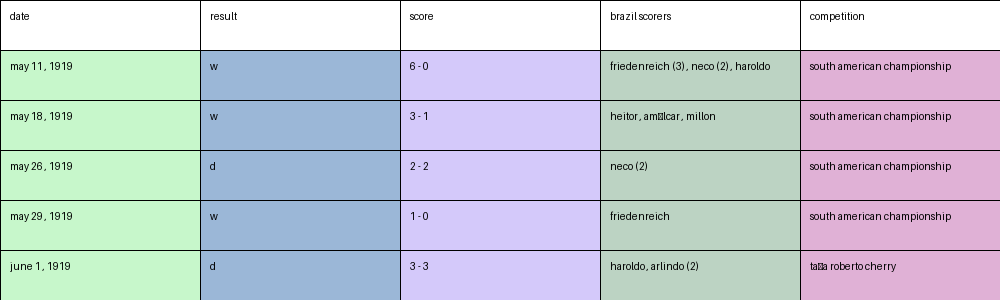

In [9]:
vlm_dataset[0]['messages'][0]['content'][1]['image']

In [11]:
vlm_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': "You are given an image of a table below. Assert whether the statement is true or false based on the table. If the statement is true, answer '1'. If the statement is false, answer '0'."},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1000x300>},
    {'type': 'text',
     'text': '### STATEMENT: haroldo be mention as a brazil scorer for 2 different game'}]},
  {'role': 'assistant', 'content': [{'type': 'text', 'text': 1}]}]}

In [10]:
FastVisionModel.for_inference(model) # Enable for inference!

image = vlm_dataset[0]['messages'][0]['content'][1]['image']
messages = vlm_dataset[0]['messages']
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The table shows that haroldo was mentioned as a brazilian scorer for 2 different games.<|eot_id|>


In [12]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from transformers import DataCollatorForSeq2Seq


FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = vlm_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # max_steps = 30,
        num_train_epochs = 2, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,

        save_strategy="epoch",  # Save at the end of each epoch
        save_steps=-1,  # Automatically save at epoch end
        save_total_limit=-1,  # No limit on the total number of saved checkpoints
        output_dir = "llama-3.2-11B-Vision-Instruct-finetuned_TabFact_ColumnColor",  # Directory to save the model
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

In [14]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 92,283 | Num Epochs = 2 | Total steps = 23,070
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 52,428,800/6,197,126,691 (0.85% trained)


Step,Training Loss
1,2.925400
2,3.187600
3,3.002000
4,2.996900
5,2.440300
6,1.970400
7,1.521800
8,1.179100
9,1.156000
10,0.792000


Unsloth: Will smartly offload gradients to save VRAM!


: 

In [12]:
from unsloth import FastLanguageModel
from transformers import AutoModelForCausalLM, AutoTokenizer


checkpoint_path = "outputs/checkpoint-2500"
model = FastLanguageModel.from_pretrained(checkpoint_path)
tokenizer = model[1]
model = model[0]

==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.50.0.dev0.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.64 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [16]:
import torch
from unsloth import FastLanguageModel
from transformers import AutoTokenizer

checkpoint_path = "outputs/checkpoint-2500"

# Load model and tokenizer, ensuring they are on GPU
model, tokenizer = FastLanguageModel.from_pretrained(checkpoint_path)
model = FastLanguageModel.for_inference(model)
model.to("cuda")  # Move model to GPU


==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.50.0.dev0.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.64 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
        (layers): ModuleList(
          (0): LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear

In [23]:
# Sample input text
table = "[['Year', 'Division', 'League', 'Regular Season', 'Playoffs', 'Open Cup', 'Avg. Attendance'], ['2001', '2', 'USL A-League', '4th, Western', 'Quarterfinals', 'Did not qualify', '7,169'], ['2002', '2', 'USL A-League', '2nd, Pacific', '1st Round', 'Did not qualify', '6,260'], ['2003', '2', 'USL A-League', '3rd, Pacific', 'Did not qualify', 'Did not qualify', '5,871'], ['2004', '2', 'USL A-League', '1st, Western', 'Quarterfinals', '4th Round', '5,628'], ['2005', '2', 'USL First Division', '5th', 'Quarterfinals', '4th Round', '6,028'], ['2006', '2', 'USL First Division', '11th', 'Did not qualify', '3rd Round', '5,575'], ['2007', '2', 'USL First Division', '2nd', 'Semifinals', '2nd Round', '6,851'], ['2008', '2', 'USL First Division', '11th', 'Did not qualify', '1st Round', '8,567'], ['2009', '2', 'USL First Division', '1st', 'Semifinals', '3rd Round', '9,734'], ['2010', '2', 'USSF D-2 Pro League', '3rd, USL (3rd)', 'Quarterfinals', '3rd Round', '10,727']]"
question = "What was the last year where this team was a part of the USL A-League?"
answer = "2004"
input_text = f"Given this table: {table}. Answer the following. question: {question}, answer: {answer}\n question:"

# Encode the input text and move it to GPU
input_ids = tokenizer.encode(input_text, return_tensors="pt").to("cuda")

# Generate output using the model
output_ids = model.generate(input_ids, max_length=2048)

# Decode the output to text
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print(f"Input: {input_text}")
print(f"Output: {output_text}")

Input: Given this table: [['Year', 'Division', 'League', 'Regular Season', 'Playoffs', 'Open Cup', 'Avg. Attendance'], ['2001', '2', 'USL A-League', '4th, Western', 'Quarterfinals', 'Did not qualify', '7,169'], ['2002', '2', 'USL A-League', '2nd, Pacific', '1st Round', 'Did not qualify', '6,260'], ['2003', '2', 'USL A-League', '3rd, Pacific', 'Did not qualify', 'Did not qualify', '5,871'], ['2004', '2', 'USL A-League', '1st, Western', 'Quarterfinals', '4th Round', '5,628'], ['2005', '2', 'USL First Division', '5th', 'Quarterfinals', '4th Round', '6,028'], ['2006', '2', 'USL First Division', '11th', 'Did not qualify', '3rd Round', '5,575'], ['2007', '2', 'USL First Division', '2nd', 'Semifinals', '2nd Round', '6,851'], ['2008', '2', 'USL First Division', '11th', 'Did not qualify', '1st Round', '8,567'], ['2009', '2', 'USL First Division', '1st', 'Semifinals', '3rd Round', '9,734'], ['2010', '2', 'USSF D-2 Pro League', '3rd, USL (3rd)', 'Quarterfinals', '3rd Round', '10,727']]. Answer th

In [28]:
# Sample input text
table = "[['Year', 'Division', 'League', 'Regular Season', 'Playoffs', 'Open Cup', 'Avg. Attendance'], ['2001', '2', 'USL A-League', '4th, Western', 'Quarterfinals', 'Did not qualify', '7,169'], ['2002', '2', 'USL A-League', '2nd, Pacific', '1st Round', 'Did not qualify', '6,260'], ['2003', '2', 'USL A-League', '3rd, Pacific', 'Did not qualify', 'Did not qualify', '5,871'], ['2004', '2', 'USL A-League', '1st, Western', 'Quarterfinals', '4th Round', '5,628'], ['2005', '2', 'USL First Division', '5th', 'Quarterfinals', '4th Round', '6,028'], ['2006', '2', 'USL First Division', '11th', 'Did not qualify', '3rd Round', '5,575'], ['2007', '2', 'USL First Division', '2nd', 'Semifinals', '2nd Round', '6,851'], ['2008', '2', 'USL First Division', '11th', 'Did not qualify', '1st Round', '8,567'], ['2009', '2', 'USL First Division', '1st', 'Semifinals', '3rd Round', '9,734'], ['2010', '2', 'USSF D-2 Pro League', '3rd, USL (3rd)', 'Quarterfinals', '3rd Round', '10,727']]"
question = "what was the name of the first team this team was a part of before becoming an independent team?"
answer = "2004"
input_text = f"Please read the following table and answer the questions. question: {question}, {table} answer:"

# Encode the input text and move it to GPU
input_ids = tokenizer.encode(input_text, return_tensors="pt").to("cuda")

# Generate output using the model
output_ids = model.generate(input_ids, max_length=2048)

# Decode the output to text
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print(f"Input: {input_text}")
print(f"Output: {output_text}")

Input: Please read the following table and answer the questions. question: what was the name of the first team this team was a part of before becoming an independent team?, [['Year', 'Division', 'League', 'Regular Season', 'Playoffs', 'Open Cup', 'Avg. Attendance'], ['2001', '2', 'USL A-League', '4th, Western', 'Quarterfinals', 'Did not qualify', '7,169'], ['2002', '2', 'USL A-League', '2nd, Pacific', '1st Round', 'Did not qualify', '6,260'], ['2003', '2', 'USL A-League', '3rd, Pacific', 'Did not qualify', 'Did not qualify', '5,871'], ['2004', '2', 'USL A-League', '1st, Western', 'Quarterfinals', '4th Round', '5,628'], ['2005', '2', 'USL First Division', '5th', 'Quarterfinals', '4th Round', '6,028'], ['2006', '2', 'USL First Division', '11th', 'Did not qualify', '3rd Round', '5,575'], ['2007', '2', 'USL First Division', '2nd', 'Semifinals', '2nd Round', '6,851'], ['2008', '2', 'USL First Division', '11th', 'Did not qualify', '1st Round', '8,567'], ['2009', '2', 'USL First Division', '1